In [1]:
import random
import pandas as pd
import numpy as np
import os
import warnings
import pickle as pkl
import holidays
warnings.filterwarnings(action='ignore') 

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True

# settings for seaborn plot sizes
import platform
sns.set(rc={'figure.figsize':(20, 10)})

if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')
    
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from darts.timeseries import TimeSeries
from darts.models import DLinearModel, AutoARIMA

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import  LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)  # type: ignore
    # torch.backends.cudnn.deterministic = True  # type: ignore
    # torch.backends.cudnn.benchmark = True  # type: ignore    

seed_everything(42) # Seed 고정

In [2]:
base_path = './data/'

In [3]:
train_data = pd.read_csv(base_path + 'train.csv')

In [4]:
def pre_train_df():
    train_df = train_data.copy()

    train_df = train_df[['ID','price(원/kg)']]
    train_df.columns = ['ID','price']
    return train_df

In [5]:
def split_id(x):
    return x.split('_')

def extract_id(x):
    return x[0]

def pre_init_feature(df):
    """ID에서 품목, 유통법인코드, 지역코드 추출, 날짜 추출"""
    split_series = df['ID'].apply(split_id)
    df['item'] = split_series.apply(lambda x: x[0])
    df['corporation'] = split_series.apply(lambda x: x[1])
    df['location'] = split_series.apply(lambda x: x[2])
    df['ymd'] = split_series.apply(lambda x: x[3])
    
def pre_ymd(df):
    # year, month, day 생성
    df['year'] = df['ymd'].apply(lambda x : int(x[:4]))
    df['month'] = df['ymd'].apply(lambda x : int(x[4:6]))
    df['day'] = df['ymd'].apply(lambda x : int(x[6:]))
    
def pre_timestamp(df):
    """year, month, day 칼럼을 사용하여 datetime 형식인 ts 칼럼 생성"""
    df['ts'] = df.apply(lambda x : pd.Timestamp(year=x.year,
                                                month=x.month,
                                                day=x.day),axis=1)
    
def pre_weekday(df):
    """ts 칼럼을 사용하여 weekday 칼럼 생성"""
    df['weekday'] = df['ts'].dt.weekday
    
def pre_holiday(df):
    """ts 칼럼을 사용하여 holiday 칼럼 생성"""
    kr_holidays = holidays.KR()
    df['holiday'] = df['weekday'].apply(lambda x : 1 if x == 6 else 0)
    df['holiday'] = df.apply(lambda x : 1 if x.ts in kr_holidays
                                        else x.holiday, axis=1)

def pre_drop(df):
    """불필요한 칼럼 삭제"""
    df.drop(['ID', 'ymd'], axis=1, inplace=True)
    
# 카테고리형 변수 리스트 설정
cat_cols = ['item', 'corporation', 'location',
            'year', 'month', 'weekday', 'holiday']

def pre_cat_label_encoder(df):
    """카테고리형 변수들을 LabelEncoder로 변환 후, 각 인코더를 딕셔너리에 저장"""
    label_encoders = {}
    for col in cat_cols:
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])
        
    # pickle로 저장
    pkl.dump(label_encoders, open('label_encoders.pkl', 'wb'))
    return label_encoders


def pre_cat_label_encoder_test(df):
    """test 데이터 변환 시 사용"""
    # pickle로 저장한 label_encoders를 불러와서 정의하기
    label_encoders = pkl.load(open('label_encoders.pkl', 'rb'))
    
    for col in cat_cols:
        try:
            df[col] = label_encoders[col].transform(df[col])
        except:
            print('train에 없는 값이 test에 존재합니다.')
            df[col] = 0
            
def pre_cat_onehot_encoder(df, drop_col=True):
    """카테고리형 변수들을 OneHotEncoder로 변환 후 N-1 인코딩을 적용"""
    onehot_encoders = {}
    for col in cat_cols:
        onehot_encoders[col] = OneHotEncoder(sparse=False, handle_unknown='ignore')
        encoded_data = onehot_encoders[col].fit_transform(df[[col]])
        
        # 원-핫 인코딩된 데이터를 DataFrame으로 변환
        encoded_df = pd.DataFrame(encoded_data, columns=onehot_encoders[col].get_feature_names_out([col]))
        
        # 첫 번째 열(기준 범주)을 제거하여 N-1 인코딩 구현
        encoded_df = encoded_df.iloc[:, 1:]
        
        # 원래 DataFrame에 병합하고, 원본 열 삭제
        if drop_col:
            df = df.drop(col, axis=1).join(encoded_df)
        else:
            df = df.join(encoded_df)
        
    # pickle로 저장
    pkl.dump(onehot_encoders, open('onehot_encoders.pkl', 'wb'))
    return df, onehot_encoders

def pre_cat_onehot_encoder_test(df):
    """테스트 데이터 변환 시 사용"""
    onehot_encoders = pkl.load(open('onehot_encoders.pkl', 'rb'))
    
    for col in cat_cols:
        try:
            encoded_data = onehot_encoders[col].transform(df[[col]])
            encoded_df = pd.DataFrame(encoded_data, columns=onehot_encoders[col].get_feature_names_out([col]))
            
            # 첫 번째 열(기준 범주)을 제거하여 N-1 인코딩 구현
            encoded_df = encoded_df.iloc[:, 1:]
            
            df = df.drop(col, axis=1).join(encoded_df)
        except:
            print(f'{col} 열에 train에 없는 값이 test에 존재합니다.')
            
    return df

In [6]:
def pre_all_label(df):
    """전체 카테고리형 변수 전처리 과정"""
    pre_init_feature(df)
    pre_ymd(df)
    pre_timestamp(df)
    pre_weekday(df)
    pre_holiday(df)
    # pre_drop(df)
    label_encoders = pre_cat_label_encoder(df)
    return df, label_encoders

def pre_all_onehot(df):
    """전체 카테고리형 변수 전처리 과정"""
    pre_init_feature(df)
    pre_ymd(df)
    pre_timestamp(df)
    pre_weekday(df)
    pre_holiday(df)
    pre_drop(df)
    df, onehot_encoders = pre_cat_onehot_encoder(df)
    return df, onehot_encoders

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping

In [8]:
# 분류 결과 시각화
from sklearn.metrics import confusion_matrix, precision_score

In [9]:
train_df = pre_train_df()
train_df, onehot_encoders = pre_all_onehot(train_df)

In [10]:
# ts 칼럼이 2023년 2월 18일 부터 2023년 3월 3일까지인 데이터만 추출 후 확인
test_df = train_df[train_df['ts'] >= '2023-02-18']
train_df = train_df[train_df['ts'] < '2023-02-18']

train_df.shape, test_df.shape

((58851, 35), (546, 35))

In [11]:
train_df['price'] = train_df['price'].apply(
    lambda x: 1 if x != 0 else 0)
test_df['price'] = test_df['price'].apply(
    lambda x: 1 if x != 0 else 0)

In [12]:
# !conda install -c apple tensorflow-deps==2.9.0	# Apple채널에서 의존성 설치
# !pip install tensorflow-macos==2.9.0		# Apple의 macos 전용 tensorflow
# !pip install tensorflow-metal==0.5.0		# GPU 지원

In [13]:
# 데이터 전처리: 'ts' 열 제거
train_df = train_df.drop(columns=['ts'])
test_df = test_df.drop(columns=['ts'])

# 훈련 데이터와 테스트 데이터 준비
X_train = train_df.drop('price', axis=1)
y_train = train_df['price']
X_test = test_df.drop('price', axis=1)
y_test = test_df['price']

In [15]:
def build_basic_model(X_train):
    # 모델 구축
    model = Sequential(name='basic_model')
    model.add(InputLayer(input_shape=X_train.shape[1]))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    # model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # 이진 분류 문제이므로 sigmoid 활성화 함수 사용
    return model

In [16]:
build_basic_model(X_train).summary()

Model: "basic_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               4352      
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12,673
Trainable params: 12,673
Non-trainable params: 0
_________________________________________________________________


In [18]:
model_basic = build_basic_model(X_train)

# 모델 컴파일
model_basic.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=[tf.keras.metrics.Precision()])

# Early stopping callback
early_stopping = EarlyStopping(monitor="val_loss",
                            min_delta=1e-3,
                            patience=5,
                            verbose=1,
                            )

In [19]:
history = model_basic.fit(X_train,
                         y_train,
                         epochs=40,
                         batch_size=32,
                         validation_split=0.2)

Epoch 1/40


2023-12-19 10:10:43.332011: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1472/1472 [==============================] - 1s 541us/step - loss: 0.3179 - precision_1: 0.8476 - val_loss: 0.2506 - val_precision_1: 0.9048
Epoch 2/40
1472/1472 [==============================] - 1s 451us/step - loss: 0.2289 - precision_1: 0.8658 - val_loss: 0.2412 - val_precision_1: 0.8937
Epoch 3/40
1472/1472 [==============================] - 1s 458us/step - loss: 0.2074 - precision_1: 0.8747 - val_loss: 0.2495 - val_precision_1: 0.9209
Epoch 4/40
1472/1472 [==============================] - 1s 476us/step - loss: 0.1945 - precision_1: 0.8818 - val_loss: 0.2509 - val_precision_1: 0.8368
Epoch 5/40
1472/1472 [==============================] - 1s 445us/step - loss: 0.1826 - precision_1: 0.8895 - val_loss: 0.3159 - val_precision_1: 0.9394
Epoch 6/40
1472/1472 [==============================] - 1s 442us/step - loss: 0.1739 - precision_1: 0.8959 - val_loss: 0.2551 - val_precision_1: 0.9109
Epoch 7/40
1472/1472 [==============================] - 1s 481us/step - loss: 0.1670 - precision_1:

In [44]:
model_basic.save(f'./model/model_basic.h5')

In [14]:
model_basic = tf.keras.models.load_model('./model/model_basic.h5')

In [15]:
# Evaluate the model on the test set (테스트 데이터에 대한 예측 결과 평가하기)
test_loss, test_pre = model_basic.evaluate(X_test, y_test)
print('Test loss     : %.4f' % test_loss)
print('Test precision : %.4f' % test_pre)

18/18 [==============================] - 0s 407us/step - loss: 0.5901 - precision_1: 0.9006
Test loss     : 0.5901
Test precision : 0.9006


2023-12-20 15:48:15.327458: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [16]:
y_pred = model_basic.predict(X_test)
y_pred = np.where(y_pred >= 0.5, 1, 0)

18/18 [==============================] - 0s 313us/step


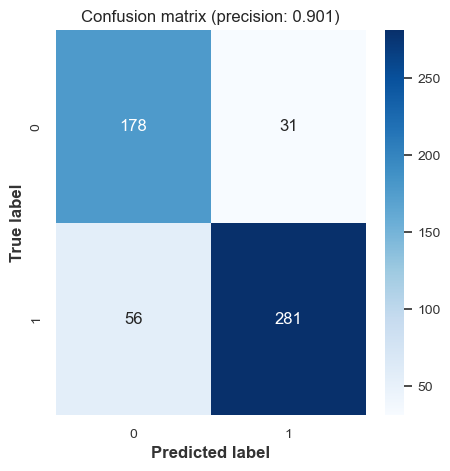

In [17]:
# confusion matrix 생성
cm = confusion_matrix(y_test, y_pred)

# confusion matrix 시각화
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix (precision: %.3f)' % precision_score(y_test, y_pred))
plt.show()

In [33]:
history.history.keys()

dict_keys(['loss', 'precision_1', 'val_loss', 'val_precision_1'])

In [35]:
def plot_training_trajectory(history):
    train_plot_kws = dict(linewidth=3., marker='o', markersize=5, alpha=.5, color='b')
    valid_plot_kws = dict(linewidth=3., marker='o', markersize=5, alpha=.5, color='r')

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))

    columns = list(history.history.keys())

    axes[0].plot(history.history[columns[0]], label='Training', **train_plot_kws)
    axes[0].plot(history.history[columns[2]], label='Validation', **valid_plot_kws)
    axes[1].plot(history.history[columns[1]], label='Training', **train_plot_kws)
    axes[1].plot(history.history[columns[3]], label='Validation', **valid_plot_kws)

    axes[0].legend(loc='best')
    axes[1].legend(loc='best')

    axes[0].grid(True, alpha=.2)
    axes[1].grid(True, alpha=.2)

    axes[0].set_xlabel('Epoch')
    axes[1].set_xlabel('Epoch')

    axes[0].set_ylabel('Loss')
    axes[1].set_ylabel('precision')

    fig.suptitle('Training Trajectory of Model (metric: precision).')
    fig.tight_layout(pad=1.01)

    plt.show(fig)

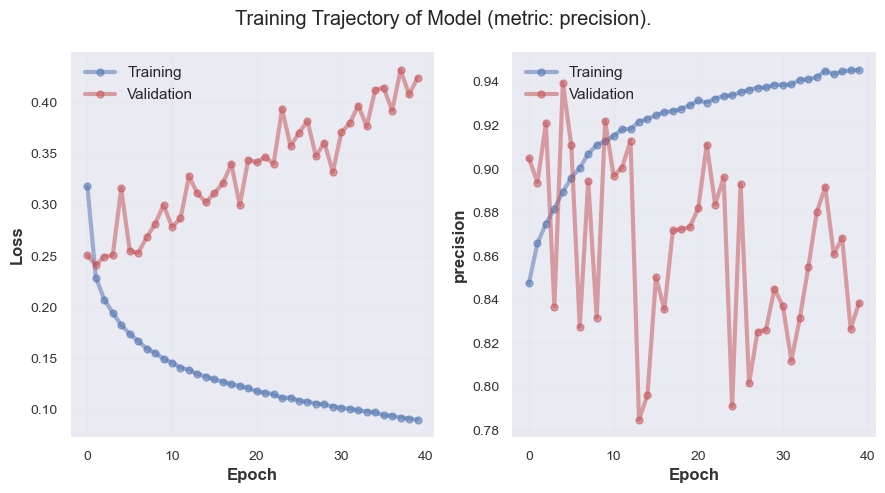

In [36]:
plot_training_trajectory(history)

# LSTM

In [41]:
def build_LSTM_model(X_train):
    # 모델 구축
    # Defining the LSTM model
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(128, return_sequences=True))
    # model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    # model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # 이진 분류 문제이므로 sigmoid 활성화 함수 사용
    return model

In [42]:
build_LSTM_model(X_train).summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 33, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [18]:
train_df = pre_train_df()

In [19]:
pre_init_feature(train_df)
pre_ymd(train_df)
pre_timestamp(train_df)
pre_weekday(train_df)
pre_holiday(train_df)
pre_drop(train_df)

In [20]:
train_df, onehot_encoders = pre_cat_onehot_encoder(train_df, drop_col=False)

In [21]:
# ts 칼럼이 2023년 2월 18일 부터 2023년 3월 3일까지인 데이터만 추출 후 확인
test_df = train_df[train_df['ts'] >= '2023-02-18']
train_df = train_df[train_df['ts'] < '2023-02-18']

train_df['price'] = train_df['price'].apply(
    lambda x: 1 if x != 0 else 0)
test_df['price'] = test_df['price'].apply(
    lambda x: 1 if x != 0 else 0)

# 데이터 전처리: 'ts' 열 제거
train_df.drop('ts', axis=1, inplace=True)
test_df.drop('ts', axis=1, inplace=True)

In [22]:
# 같은 item, corporation, location 별 리스트 생성
type_list = train_df.groupby(['item', 'corporation', 'location']).groups.keys()
type_list = list(type_list)

In [77]:

# 같은 item, corporation, location 별로 LSTM 모델 훈련
model_dict = {}
history_dict = {}

for i in range(len(type_list)):
    print(f'{i+1}/{len(type_list)}')
    item = type_list[i][0]
    corporation = type_list[i][1]
    location = type_list[i][2]
    
    # 같은 item, corporation, location 별로 데이터 추출
    temp_df = train_df[(train_df['item'] == item) &
                       (train_df['corporation'] == corporation) &
                       (train_df['location'] == location)]
    
    # 훈련 데이터와 테스트 데이터 준비
    temp_df = temp_df.drop(cat_cols, axis=1)
    X_train = temp_df.drop('price', axis=1)
    y_train = temp_df['price']
    
    # 모델 구축
    model = build_LSTM_model(X_train)
    
    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.Precision()])
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor="val_loss",
                                min_delta=1e-3,
                                patience=5,
                                verbose=1,
                                )
    
    # 모델 훈련
    history = model.fit(X_train.values.reshape(-1, X_train.shape[1], 1),
                        y_train,
                        epochs=10,
                        batch_size=32,
                        validation_split=0.2,
                        callbacks=[early_stopping],
                        )
    
    # 모델 저장
    model_dict[f'{item}_{corporation}_{location}'] = model
    history_dict[f'{item}_{corporation}_{location}'] = history
    
    # 모델 저장
    model.save(f'./model/{item}_{corporation}_{location}.h5')

1/39
Epoch 1/10
38/38 [==============================] - 3s 34ms/step - loss: 0.6872 - precision_121: 0.6432 - val_loss: 0.6798 - val_precision_121: 0.6111
Epoch 2/10
38/38 [==============================] - 1s 23ms/step - loss: 0.6601 - precision_121: 0.6804 - val_loss: 0.6397 - val_precision_121: 0.4545
Epoch 3/10
38/38 [==============================] - 1s 20ms/step - loss: 0.5767 - precision_121: 0.7018 - val_loss: 0.5071 - val_precision_121: 0.6879
Epoch 4/10
38/38 [==============================] - 1s 21ms/step - loss: 0.3460 - precision_121: 0.8465 - val_loss: 0.2809 - val_precision_121: 0.8397
Epoch 5/10
38/38 [==============================] - 1s 21ms/step - loss: 0.2594 - precision_121: 0.8898 - val_loss: 0.3014 - val_precision_121: 0.8448
Epoch 6/10
38/38 [==============================] - 1s 21ms/step - loss: 0.2537 - precision_121: 0.8781 - val_loss: 0.3565 - val_precision_121: 0.7687
Epoch 7/10
38/38 [==============================] - 1s 21ms/step - loss: 0.2297 - precisi

In [23]:
# 모델 불러오기
model_dict = {}
for i in range(len(type_list)):
    item = type_list[i][0]
    corporation = type_list[i][1]
    location = type_list[i][2]
    
    model_dict[f'{item}_{corporation}_{location}'] = tf.keras.models.load_model(f'./model/{item}_{corporation}_{location}.h5')

NameError: name 'history_dict' is not defined

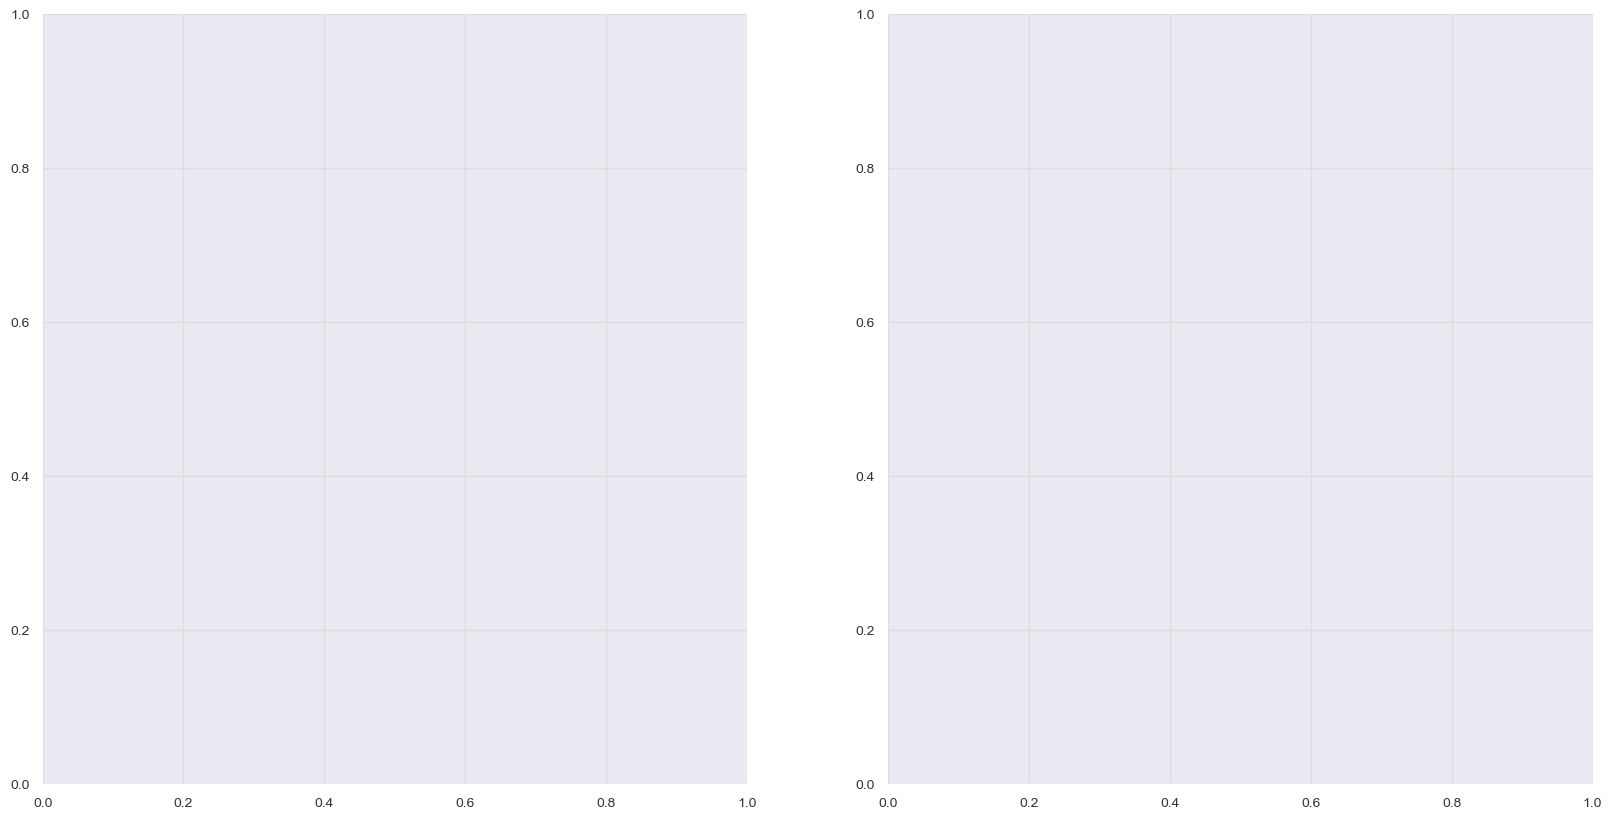

In [24]:
# history_dict 시각화
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for key in history_dict.keys():
    train_plot_kws = dict(linewidth=3., marker='o', markersize=5, alpha=.5, color='b')
    valid_plot_kws = dict(linewidth=3., marker='o', markersize=5, alpha=.5, color='r')

    columns = list(history_dict[key].history.keys())
    
    axes[0].plot(history_dict[key].history[columns[0]], label='Training', **train_plot_kws)
    axes[0].plot(history_dict[key].history[columns[2]], label='Validation', **valid_plot_kws)
    axes[1].plot(history_dict[key].history[columns[1]], label='Training', **train_plot_kws)
    axes[1].plot(history_dict[key].history[columns[3]], label='Validation', **valid_plot_kws)

# axes[0].legend(loc='best')
# axes[1].legend(loc='best')

axes[0].grid(True, alpha=.2)
axes[1].grid(True, alpha=.2)

axes[0].set_xlabel('Epoch')
axes[1].set_xlabel('Epoch')

axes[0].set_ylabel('Loss')
axes[1].set_ylabel('precision')

fig.suptitle('Training Trajectory of Model (metric: precision).')
fig.tight_layout(pad=1.01)

plt.show(fig)


In [25]:
# test의 특정 item, corporation, location에 대한 예측 결과를 저장할 DataFrame 생성
def test_precision(item, corporation, location):
    # 모델 불러오기
    model = tf.keras.models.load_model(f'./model/{item}_{corporation}_{location}.h5')
    
    # 같은 item, corporation, location 별로 데이터 추출
    temp_df = test_df[(test_df['item'] == item) &
                      (test_df['corporation'] == corporation) &
                      (test_df['location'] == location)]
    
    # 테스트 데이터 준비
    temp_df = temp_df.drop(cat_cols, axis=1)
    X_test = temp_df.drop('price', axis=1)
    y_test = temp_df['price']
    
    # 예측
    y_pred = model.predict(X_test.values.reshape(-1, X_test.shape[1], 1))
    y_pred = np.where(y_pred >= 0.5, 1, 0)
    
    return y_test, y_pred

# test의 전체 예측 결과를 저장할 DataFrame 생성
y_test_all = []
y_pred_all = []

for i in range(len(type_list)):
    print(f'{i+1}/{len(type_list)}')
    item = type_list[i][0]
    corporation = type_list[i][1]
    location = type_list[i][2]
    
    # 예측
    y_test, y_pred = test_precision(item, corporation, location)
    
    # 예측 결과 저장
    y_test_all.extend(y_test)
    y_pred_all.extend(y_pred)

1/39
1/1 [==============================] - 0s 347ms/step
2/39
1/1 [==============================] - 0s 373ms/step
3/39
1/1 [==============================] - 1s 592ms/step
4/39
1/1 [==============================] - 0s 336ms/step
5/39
1/1 [==============================] - 0s 337ms/step
6/39
1/1 [==============================] - 0s 335ms/step
7/39
1/1 [==============================] - 0s 334ms/step
8/39
1/1 [==============================] - 0s 344ms/step
9/39
1/1 [==============================] - 0s 338ms/step
10/39
1/1 [==============================] - 0s 335ms/step
11/39
1/1 [==============================] - 0s 361ms/step
12/39
1/1 [==============================] - 0s 331ms/step
13/39
1/1 [==============================] - 0s 340ms/step
14/39
1/1 [==============================] - 1s 651ms/step
15/39
1/1 [==============================] - 0s 332ms/step
16/39
1/1 [==============================] - 0s 335ms/step
17/39
1/1 [==============================] - 0s 329ms/step
18/39


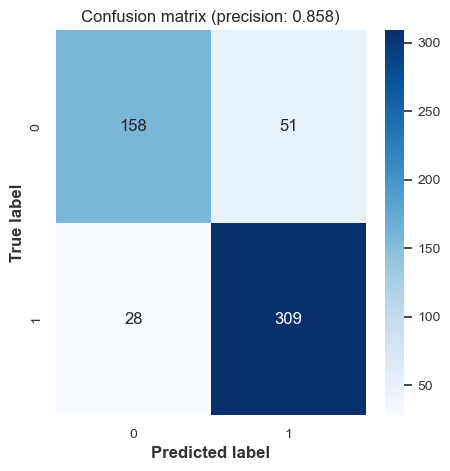

In [26]:
# confusion matrix 생성
cm = confusion_matrix(y_test_all, y_pred_all)

# confusion matrix 시각화
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix (precision: %.3f)' % precision_score(y_test_all, y_pred_all))
plt.show()

In [54]:
train_df = pre_train_df()

pre_init_feature(train_df)
pre_ymd(train_df)
pre_timestamp(train_df)
pre_weekday(train_df)
pre_holiday(train_df)
pre_drop(train_df)

train_df, onehot_encoders = pre_cat_onehot_encoder(train_df, drop_col=False)

# ts 칼럼이 2023년 2월 18일 부터 2023년 3월 3일까지인 데이터만 추출 후 확인
test_df = train_df[train_df['ts'] >= '2023-02-18']
train_df = train_df[train_df['ts'] < '2023-02-18']

train_df['price'] = train_df['price'].apply(
    lambda x: 1 if x != 0 else 0)
test_df['price'] = test_df['price'].apply(
    lambda x: 1 if x != 0 else 0)

# 데이터 전처리: 'ts' 열 제거
train_df.drop('ts', axis=1, inplace=True)
test_df.drop('ts', axis=1, inplace=True)

# 같은 item, corporation, location 별 리스트 생성
type_list = train_df.groupby(['item', 'corporation', 'location']).groups.keys()
type_list = list(type_list)

In [55]:
# 같은 item, corporation, location 별로 Basic 모델 훈련
model_dict = {}
history_dict = {}

for i in range(len(type_list)):
    print(f'{i+1}/{len(type_list)}')
    item = type_list[i][0]
    corporation = type_list[i][1]
    location = type_list[i][2]
    
    # 같은 item, corporation, location 별로 데이터 추출
    temp_df = train_df[(train_df['item'] == item) &
                       (train_df['corporation'] == corporation) &
                       (train_df['location'] == location)]
    
    # 훈련 데이터와 테스트 데이터 준비
    temp_df = temp_df.drop(cat_cols, axis=1)
    X_train = temp_df.drop('price', axis=1)
    y_train = temp_df['price']
    
    # 모델 구축
    model = build_basic_model(X_train)
    
    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.Precision()])
    
    # 모델 훈련
    history = model_base.fit(X_train,
                         y_train,
                         epochs=40,
                         batch_size=32,
                         validation_split=0.2)
    
    # 모델 저장
    model_dict[f'{item}_{corporation}_{location}'] = model
    history_dict[f'{item}_{corporation}_{location}'] = history
    
    # 모델 저장
    model.save(f'./model/basic/{item}_{corporation}_{location}.h5')

1/39
Epoch 1/40
38/38 [==============================] - 0s 3ms/step - loss: 0.6526 - precision: 0.6391 - val_loss: 0.5882 - val_precision: 0.8529
Epoch 2/40
38/38 [==============================] - 0s 705us/step - loss: 0.4929 - precision: 0.8426 - val_loss: 0.4893 - val_precision: 0.7583
Epoch 3/40
38/38 [==============================] - 0s 677us/step - loss: 0.3305 - precision: 0.8946 - val_loss: 0.3857 - val_precision: 0.8812
Epoch 4/40
38/38 [==============================] - 0s 672us/step - loss: 0.2507 - precision: 0.9079 - val_loss: 0.3345 - val_precision: 0.8738
Epoch 5/40
38/38 [==============================] - 0s 643us/step - loss: 0.2189 - precision: 0.9068 - val_loss: 0.3335 - val_precision: 0.8271
Epoch 6/40
38/38 [==============================] - 0s 680us/step - loss: 0.2018 - precision: 0.9058 - val_loss: 0.2653 - val_precision: 0.8824
Epoch 7/40
38/38 [==============================] - 0s 651us/step - loss: 0.1797 - precision: 0.9119 - val_loss: 0.2551 - val_precisi

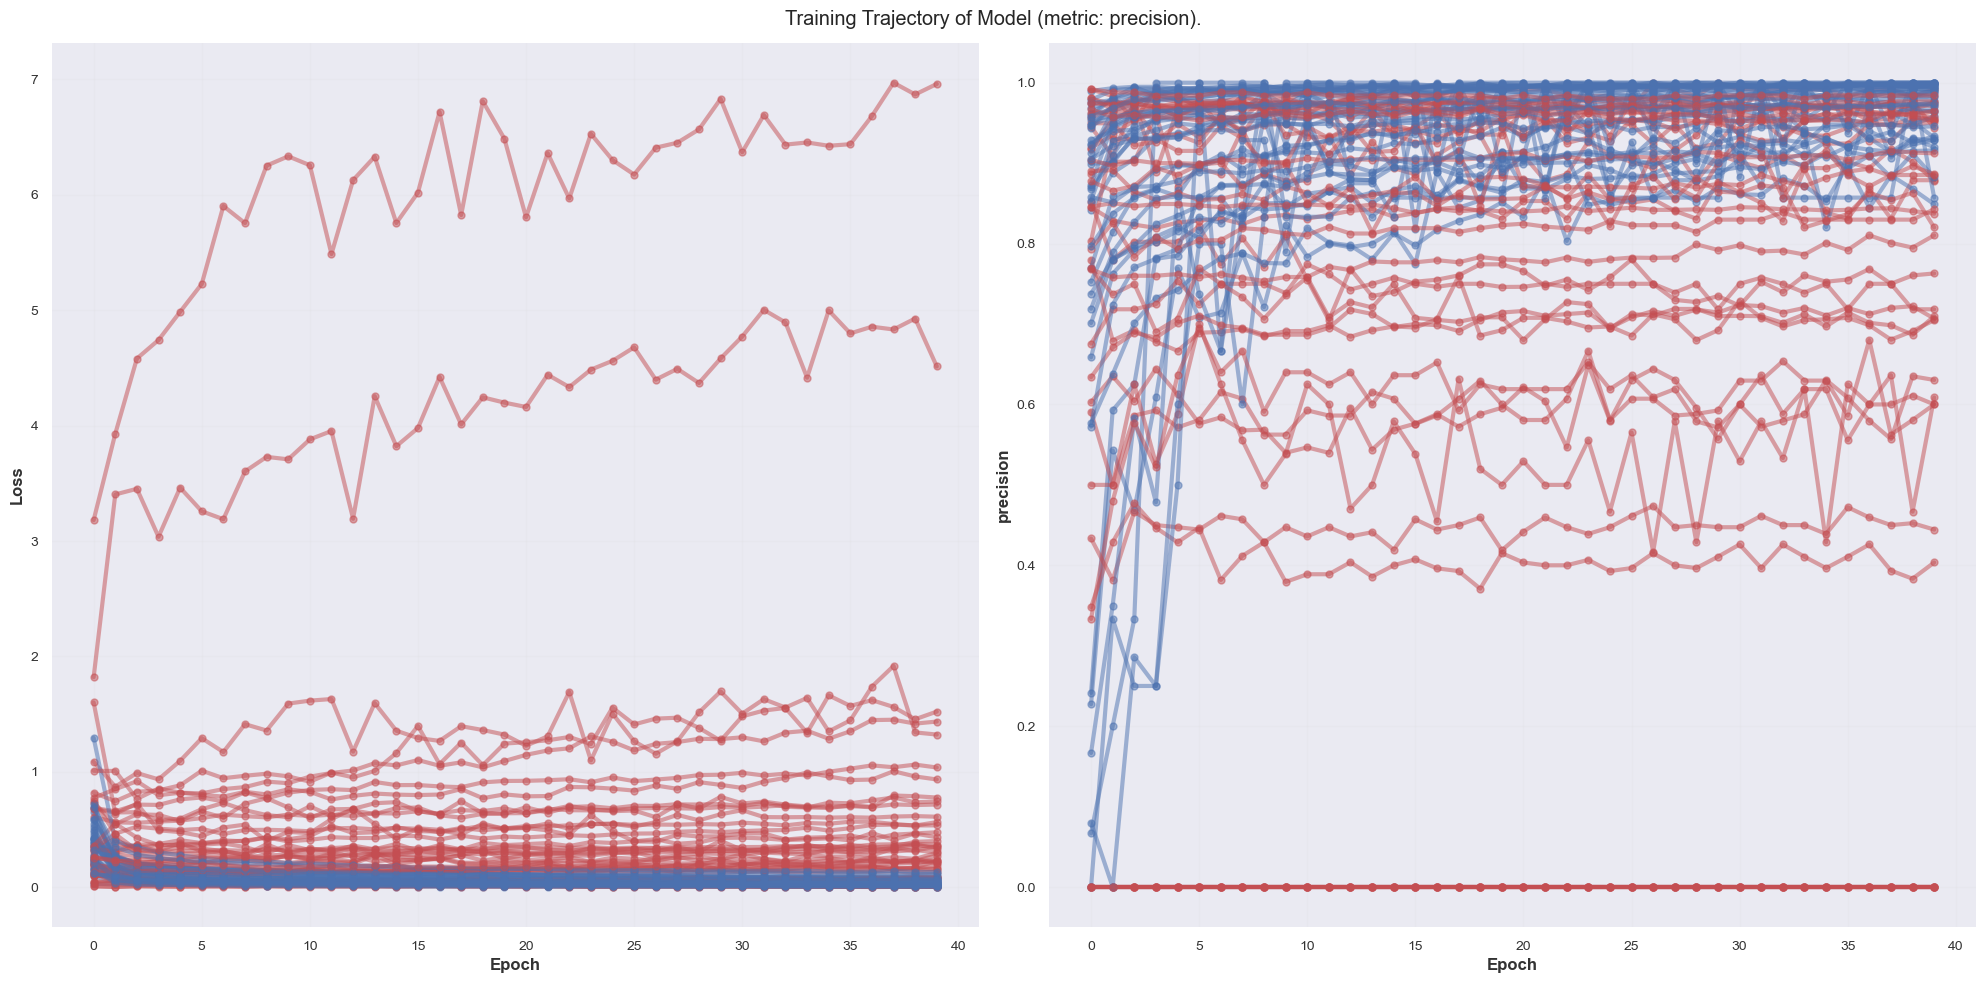

In [185]:
# history_dict 시각화
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for key in history_dict.keys():
    train_plot_kws = dict(linewidth=3., marker='o', markersize=5, alpha=.5, color='b')
    valid_plot_kws = dict(linewidth=3., marker='o', markersize=5, alpha=.5, color='r')

    columns = list(history_dict[key].history.keys())
    
    axes[0].plot(history_dict[key].history[columns[0]], label='Training', **train_plot_kws)
    axes[0].plot(history_dict[key].history[columns[2]], label='Validation', **valid_plot_kws)
    axes[1].plot(history_dict[key].history[columns[1]], label='Training', **train_plot_kws)
    axes[1].plot(history_dict[key].history[columns[3]], label='Validation', **valid_plot_kws)

# axes[0].legend(loc='best')
# axes[1].legend(loc='best')

axes[0].grid(True, alpha=.2)
axes[1].grid(True, alpha=.2)

axes[0].set_xlabel('Epoch')
axes[1].set_xlabel('Epoch')

axes[0].set_ylabel('Loss')
axes[1].set_ylabel('precision')

fig.suptitle('Training Trajectory of Model (metric: precision).')
fig.tight_layout(pad=1.01)

plt.show(fig)


In [56]:
# test의 특정 item, corporation, location에 대한 예측 결과를 저장할 DataFrame 생성
def test_precision(item, corporation, location):
    # 모델 불러오기
    model = tf.keras.models.load_model(f'./model/basic/{item}_{corporation}_{location}.h5')
    
    # 같은 item, corporation, location 별로 데이터 추출
    temp_df = test_df[(test_df['item'] == item) &
                      (test_df['corporation'] == corporation) &
                      (test_df['location'] == location)]
    
    # 테스트 데이터 준비
    temp_df = temp_df.drop(cat_cols, axis=1)
    X_test = temp_df.drop('price', axis=1)
    y_test = temp_df['price']
    
    # 예측
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred >= 0.5, 1, 0)
    # print(precision_score(y_test, y_pred))
    return y_test, y_pred

# test의 전체 예측 결과를 저장할 DataFrame 생성
y_test_all = []
y_pred_all = []

for i in range(len(type_list)):
    print(f'{i+1}/{len(type_list)}')
    item = type_list[i][0]
    corporation = type_list[i][1]
    location = type_list[i][2]
    
    # 예측
    y_test, y_pred = test_precision(item, corporation, location)
    
    # 예측 결과 저장
    y_test_all.extend(y_test)
    y_pred_all.extend(y_pred)


1/39


1/1 [==============================] - 0s 32ms/step
2/39
1/1 [==============================] - 0s 20ms/step
3/39
1/1 [==============================] - 0s 20ms/step
4/39
1/1 [==============================] - 0s 20ms/step
5/39
1/1 [==============================] - 0s 23ms/step
6/39
1/1 [==============================] - 0s 20ms/step
7/39
1/1 [==============================] - 0s 21ms/step
8/39
1/1 [==============================] - 0s 20ms/step
9/39
1/1 [==============================] - 0s 20ms/step
10/39
1/1 [==============================] - 0s 19ms/step
11/39
1/1 [==============================] - 0s 23ms/step
12/39
1/1 [==============================] - 0s 22ms/step
13/39
1/1 [==============================] - 0s 20ms/step
14/39
1/1 [==============================] - 0s 20ms/step
15/39
1/1 [==============================] - 0s 21ms/step
16/39
1/1 [==============================] - 0s 20ms/step
17/39
1/1 [==============================] - 0s 20ms/step
18/39
1/1 [=================

Text(0.5, 1.0, 'Confusion matrix (precision: 0.642)')

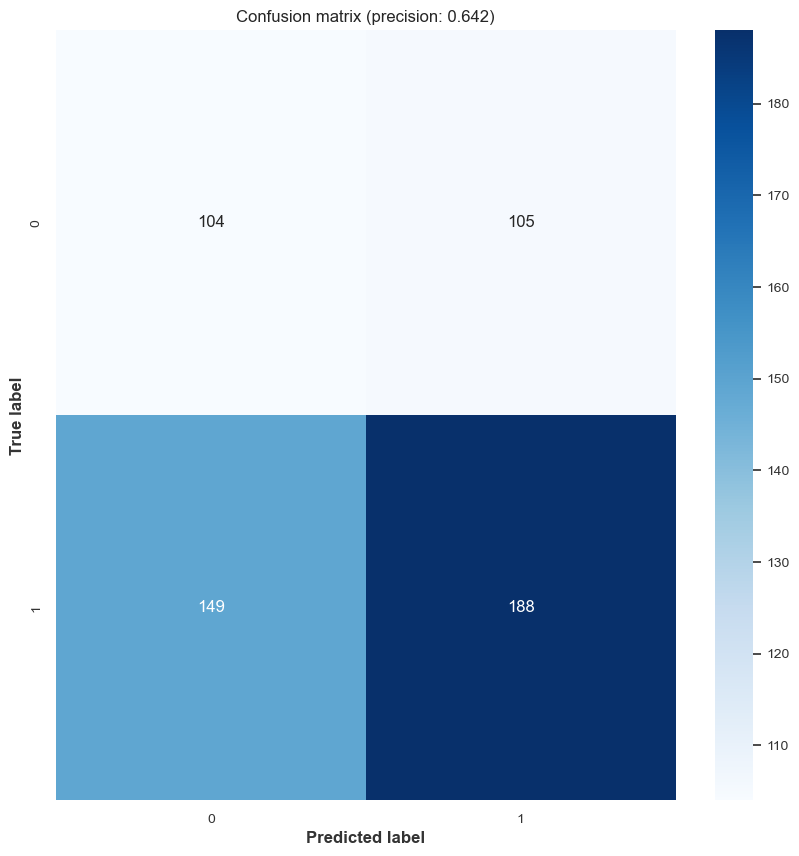

In [57]:
# confusion matrix 생성
cm = confusion_matrix(y_test_all, y_pred_all)

# confusion matrix 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix (precision: %.3f)' % precision_score(y_test_all, y_pred_all))

# Upgrade LSTM model

In [58]:
train_df = pre_train_df()

pre_init_feature(train_df)
pre_ymd(train_df)
pre_timestamp(train_df)
pre_weekday(train_df)
pre_holiday(train_df)
pre_drop(train_df)

train_df, onehot_encoders = pre_cat_onehot_encoder(train_df, drop_col=False)

# ts 칼럼이 2023년 2월 18일 부터 2023년 3월 3일까지인 데이터만 추출 후 확인
test_df = train_df[train_df['ts'] >= '2023-02-18']
train_df = train_df[train_df['ts'] < '2023-02-18']

train_df['price'] = train_df['price'].apply(
    lambda x: 1 if x != 0 else 0)
test_df['price'] = test_df['price'].apply(
    lambda x: 1 if x != 0 else 0)

# 데이터 전처리: 'ts' 열 제거
train_df.drop('ts', axis=1, inplace=True)
test_df.drop('ts', axis=1, inplace=True)

In [59]:
# 같은 item, corporation, location 별 리스트 생성
type_list = train_df.groupby(['item', 'corporation', 'location']).groups.keys()
type_list = list(type_list)

In [60]:
def build_LSTM_Upgrade_model(X_train):
    # 모델 구축
    # Defining the LSTM model
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # 이진 분류 문제이므로 sigmoid 활성화 함수 사용
    return model

In [61]:
build_LSTM_Upgrade_model(X_train).summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_82 (LSTM)              (None, 33, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 33, 128)           0         
                                                                 
 lstm_83 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_170 (Dense)           (None, 1)                 129       
                                                                 
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________


In [62]:
# 같은 item, corporation, location 별로 LSTM 모델 훈련
model_dict = {}
history_dict = {}

for i in range(len(type_list)):
    print(f'{i+1}/{len(type_list)}')
    item = type_list[i][0]
    corporation = type_list[i][1]
    location = type_list[i][2]
    
    # 같은 item, corporation, location 별로 데이터 추출
    temp_df = train_df[(train_df['item'] == item) &
                       (train_df['corporation'] == corporation) &
                       (train_df['location'] == location)]
    
    # 훈련 데이터와 테스트 데이터 준비
    temp_df = temp_df.drop(cat_cols, axis=1)
    X_train = temp_df.drop('price', axis=1)
    y_train = temp_df['price']
    
    # 모델 구축
    model = build_LSTM_Upgrade_model(X_train)
    
    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.Precision()])
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor="val_loss",
                                min_delta=1e-3,
                                patience=5,
                                verbose=1,
                                )
    
    # 모델 훈련
    history = model.fit(X_train.values.reshape(-1, X_train.shape[1], 1),
                        y_train,
                        epochs=100,
                        batch_size=64,
                        validation_split=0.2,
                        callbacks=[early_stopping],
                        )
    
    # 모델 저장
    model_dict[f'{item}_{corporation}_{location}'] = model
    history_dict[f'{item}_{corporation}_{location}'] = history
    
    # 모델 저장
    model.save(f'./model/upgrade/{item}_{corporation}_{location}.h5')

1/39
Epoch 1/100
19/19 [==============================] - 3s 56ms/step - loss: 0.6878 - precision_81: 0.6062 - val_loss: 0.6802 - val_precision_81: 0.4571
Epoch 2/100
19/19 [==============================] - 1s 35ms/step - loss: 0.6722 - precision_81: 0.6570 - val_loss: 0.6587 - val_precision_81: 0.4286
Epoch 3/100
19/19 [==============================] - 1s 34ms/step - loss: 0.6266 - precision_81: 0.6929 - val_loss: 0.6086 - val_precision_81: 0.6986
Epoch 4/100
19/19 [==============================] - 1s 34ms/step - loss: 0.5762 - precision_81: 0.7274 - val_loss: 0.5969 - val_precision_81: 0.8065
Epoch 5/100
19/19 [==============================] - 1s 34ms/step - loss: 0.4645 - precision_81: 0.8074 - val_loss: 0.4343 - val_precision_81: 0.7095
Epoch 6/100
19/19 [==============================] - 1s 39ms/step - loss: 0.3527 - precision_81: 0.8699 - val_loss: 0.2698 - val_precision_81: 0.8309
Epoch 7/100
19/19 [==============================] - 1s 37ms/step - loss: 0.2807 - precision_81

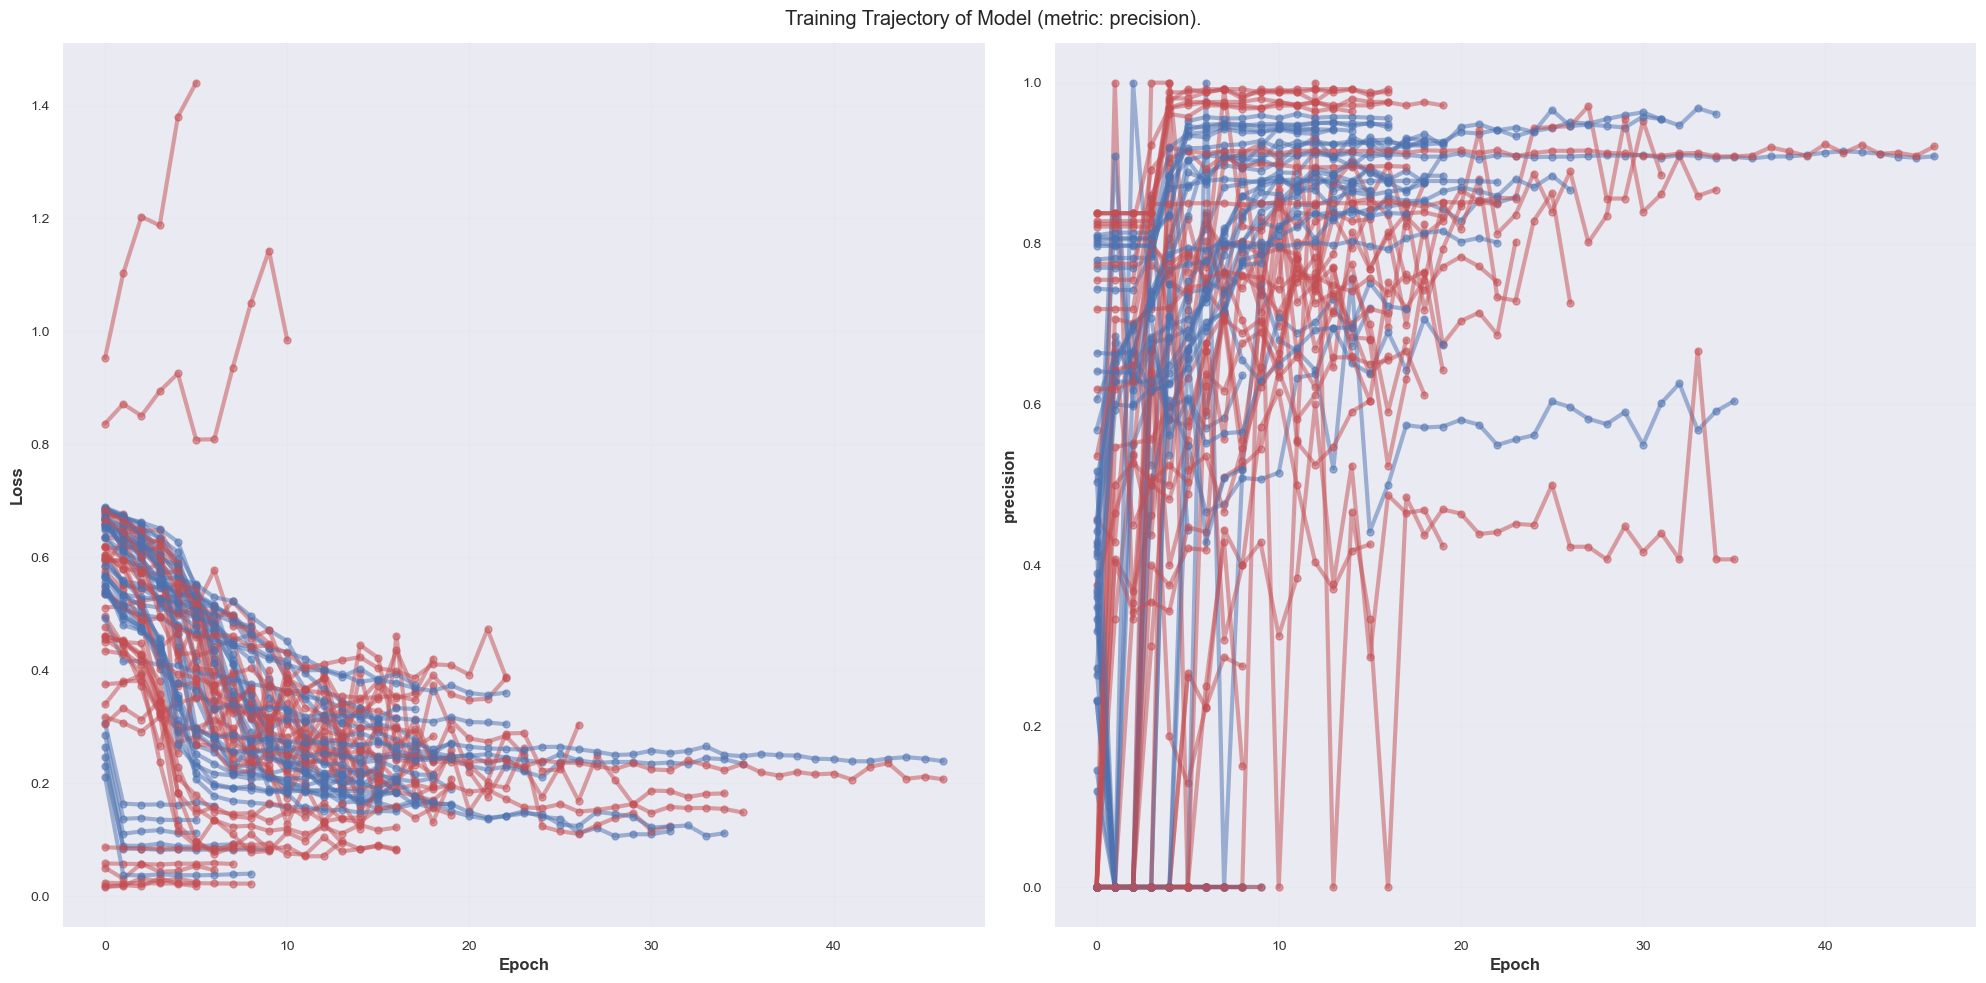

In [63]:
# history_dict 시각화
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for key in history_dict.keys():
    train_plot_kws = dict(linewidth=3., marker='o', markersize=5, alpha=.5, color='b')
    valid_plot_kws = dict(linewidth=3., marker='o', markersize=5, alpha=.5, color='r')

    columns = list(history_dict[key].history.keys())
    
    axes[0].plot(history_dict[key].history[columns[0]], label='Training', **train_plot_kws)
    axes[0].plot(history_dict[key].history[columns[2]], label='Validation', **valid_plot_kws)
    axes[1].plot(history_dict[key].history[columns[1]], label='Training', **train_plot_kws)
    axes[1].plot(history_dict[key].history[columns[3]], label='Validation', **valid_plot_kws)

# axes[0].legend(loc='best')
# axes[1].legend(loc='best')

axes[0].grid(True, alpha=.2)
axes[1].grid(True, alpha=.2)

axes[0].set_xlabel('Epoch')
axes[1].set_xlabel('Epoch')

axes[0].set_ylabel('Loss')
axes[1].set_ylabel('precision')

fig.suptitle('Training Trajectory of Model (metric: precision).')
fig.tight_layout(pad=1.01)

plt.show(fig)


In [66]:
# test의 특정 item, corporation, location에 대한 예측 결과를 저장할 DataFrame 생성
def test_precision(item, corporation, location):
    # 모델 불러오기
    model = tf.keras.models.load_model(f'./model/upgrade/{item}_{corporation}_{location}.h5')
    
    # 같은 item, corporation, location 별로 데이터 추출
    temp_df = test_df[(test_df['item'] == item) &
                      (test_df['corporation'] == corporation) &
                      (test_df['location'] == location)]
    
    # 테스트 데이터 준비
    temp_df = temp_df.drop(cat_cols, axis=1)
    X_test = temp_df.drop('price', axis=1)
    y_test = temp_df['price']
    
    # 예측
    y_pred = model.predict(X_test.values.reshape(-1, X_test.shape[1], 1))
    y_pred = np.where(y_pred >= 0.5, 1, 0)
    
    return y_test, y_pred

# test의 전체 예측 결과를 저장할 DataFrame 생성
y_test_all = []
y_pred_all = []

for i in range(len(type_list)):
    print(f'{i+1}/{len(type_list)}')
    item = type_list[i][0]
    corporation = type_list[i][1]
    location = type_list[i][2]
    
    # 예측
    y_test, y_pred = test_precision(item, corporation, location)
    
    # 예측 결과 저장
    y_test_all.extend(y_test)
    y_pred_all.extend(y_pred)

1/39
1/1 [==============================] - 0s 365ms/step
2/39
1/1 [==============================] - 0s 326ms/step
3/39
1/1 [==============================] - 0s 325ms/step
4/39
1/1 [==============================] - 0s 328ms/step
5/39
1/1 [==============================] - 0s 328ms/step
6/39
1/1 [==============================] - 0s 328ms/step
7/39
1/1 [==============================] - 0s 329ms/step
8/39
1/1 [==============================] - 0s 328ms/step
9/39
1/1 [==============================] - 0s 331ms/step
10/39
1/1 [==============================] - 0s 326ms/step
11/39
1/1 [==============================] - 0s 324ms/step
12/39
1/1 [==============================] - 0s 352ms/step
13/39
1/1 [==============================] - 0s 330ms/step
14/39
1/1 [==============================] - 0s 322ms/step
15/39
1/1 [==============================] - 0s 331ms/step
16/39
1/1 [==============================] - 0s 336ms/step
17/39
1/1 [==============================] - 0s 325ms/step
18/39


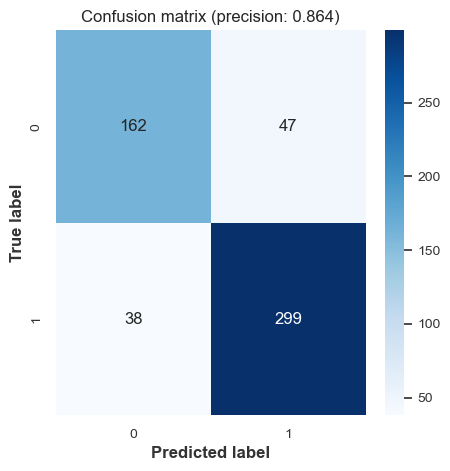

In [70]:
# confusion matrix 생성
cm = confusion_matrix(y_test_all, y_pred_all)

# confusion matrix 시각화
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix (precision: %.3f)' % precision_score(y_test_all, y_pred_all))
plt.show()